In [14]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM
import os
import numpy as np

from pillow_heif import register_heif_opener
register_heif_opener()

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float32
model_name = "microsoft/Florence-2-large"

In [3]:
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch_dtype, trust_remote_code=True).to(device).eval()
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)

C:\Users\Otniel\AppData\Roaming\Python\Python310\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

In [5]:
def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)
    with torch.no_grad():
        generated_ids = model.generate(input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"],
                                          max_new_tokens=512, num_beams=3)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

In [33]:
img_dir = r"D:\Datasets\Diffusion\dataset_ilia"
img_paths = [os.path.join(img_dir, file) for file in os.listdir(img_dir) if os.path.splitext(file)[-1].lower() in ['.jpg', '.png', '.jpeg', '.heic']]

In [34]:
img_paths[4]

'D:\\Datasets\\Diffusion\\dataset_ilia\\5373054416179031555.jpg'

In [39]:
image = Image.open(img_paths[0]).rotate(0)

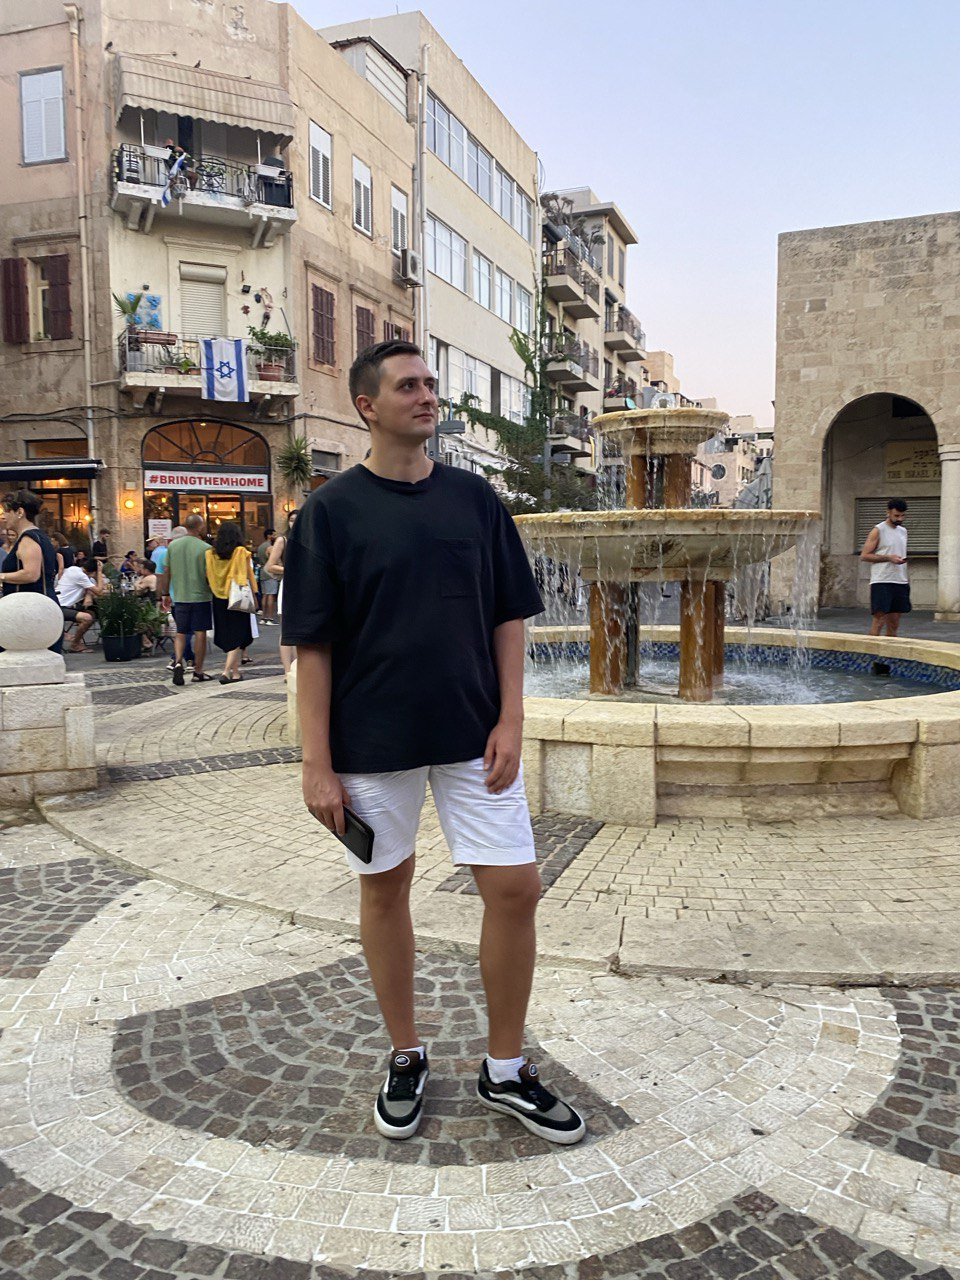

In [40]:
image

# Rotate

In [41]:
def get_bboxes_person_head(image):
    person = run_example('<CAPTION_TO_PHRASE_GROUNDING>', image, "person")
    if len(person['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']) > 1:  # chooce max area
        areas = [(bb[2]-bb[0]) * (bb[3]-bb[1]) for bb in person['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']]
        person['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes'] = [person['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes'][np.argmax(areas)]]
    person_bbox = person['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']
    head = run_example('<CAPTION_TO_PHRASE_GROUNDING>', image, "head")
    if len(person['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']) == 0:
        return [], [head[0]]
    if len(head['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']) > 1:  # chooce smallest inside person box
        centers = [[(bb[2]+bb[0])/2, (bb[3]+bb[1])/2] for bb in head['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']]
        new_bboxes = []
        for i in range(len(centers)):
            if person_bbox[0][0] <= centers[i][0] <= person_bbox[0][2] and person_bbox[0][1] <= centers[i][1] <= person_bbox[0][3]:
               new_bboxes.append(head['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes'][i])
        if len(new_bboxes) > 1:
            areas = [(bb[2]-bb[0]) * (bb[3]-bb[1]) for bb in new_bboxes]
            new_bboxes = [new_bboxes[np.argmin(areas)]]
        head['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes'] = new_bboxes
    head_bbox = head['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']
    if len(head_bbox) == 0:
        return person_bbox, []
    return person_bbox, head_bbox

In [42]:
person, head = get_bboxes_person_head(image)
(person, head)

([[276.9599914550781, 336.0, 589.9199829101562, 1147.52001953125]],
 [[346.0799865722656, 337.2799987792969, 442.0799865722656, 442.239990234375]])

In [43]:
person = run_example('<CAPTION_TO_PHRASE_GROUNDING>', image, "person")
person

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[276.9599914550781,
    336.0,
    589.9199829101562,
    1147.52001953125]],
  'labels': ['person']}}

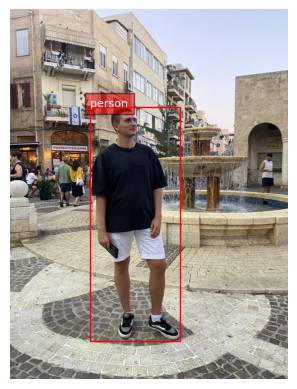

In [44]:
plot_bbox(image, person['<CAPTION_TO_PHRASE_GROUNDING>'])

In [45]:
head = run_example('<CAPTION_TO_PHRASE_GROUNDING>', image, "head")
head

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[346.0799865722656,
    337.2799987792969,
    442.0799865722656,
    442.239990234375]],
  'labels': ['head']}}

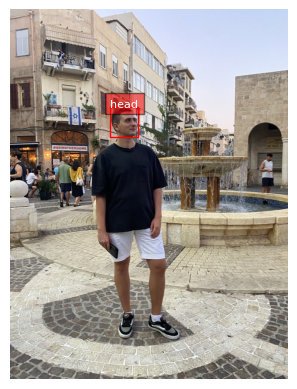

In [46]:
plot_bbox(image, head['<CAPTION_TO_PHRASE_GROUNDING>'])

In [47]:
def rotate_if_needed(image, person_bbox, head_bbox):
    if isinstance(person_bbox, dict): person_bbox = person_bbox['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']
    if isinstance(head_bbox, dict): head_bbox = head_bbox['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes']
    # x1, y1, x2, y2 = bbox
    width, height = image.width, image.height
    closest_side = [abs(ph[0] - ph[1]) for ph in zip(person_bbox[0], head_bbox[0])]

    smolest_idx = 1
    smolest_side = 1000
    for i, cs in enumerate(closest_side):
        if cs < smolest_side:
            smolest_side = cs
            smolest_idx = i
            
    if closest_side[1] / min(width, height) < 0.03:
        smolest_idx = 1
    angle = [-1, 0, 1, 2][smolest_idx]

    if angle == -1:
        person_bbox = [[height - person_bbox[0][3], person_bbox[0][0], height - person_bbox[0][1], person_bbox[0][2]]]
        head_bbox = [[height - head_bbox[0][3], head_bbox[0][0], height - head_bbox[0][1], head_bbox[0][2]]]
    elif angle == 1:
        person_bbox = [[person_bbox[0][1], width - person_bbox[0][2], person_bbox[0][3], width - person_bbox[0][0]]]
        head_bbox = [[head_bbox[0][1], width - head_bbox[0][2], head_bbox[0][3], width - head_bbox[0][0]]]
    elif angle == 2:
        person_bbox = [[width-person_bbox[0][2], height - person_bbox[0][3], width-person_bbox[0][0], height - person_bbox[0][1]]]
        head_bbox = [[width-head_bbox[0][2], height - head_bbox[0][3], width-head_bbox[0][0], height - head_bbox[0][1]]]

    if angle != 0:
        return Image.fromarray(np.rot90(image, k=angle)), person_bbox, head_bbox
    return image, person_bbox, head_bbox

In [69]:
image_rotated, person_bbox, head_bbox = rotate_if_needed(image, person, head)

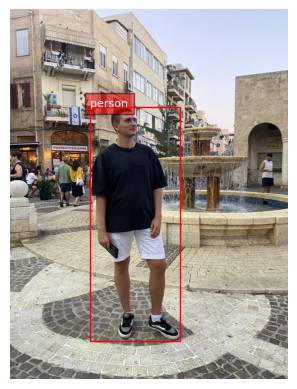

In [77]:
plot_bbox(image_rotated, {"bboxes":person_bbox, "labels": ["person"]})

# Resize

In [83]:
def crop_resize(image, size, person_bbox=None, head_bbox=None):
    width, height = image.width, image.height
    aspect = height / width
    margin = int(min(height, width) * 0.05)
    bbox = person_bbox if person_bbox is not None else head_bbox

    if aspect > 1:  # tall
        cut_size = (aspect - 1) * width
        if height - bbox[0][3] > cut_size + margin:
            # left, top, right, bottom
            image = image.crop([0, 0, width, height - int(cut_size)])
        else:
            bot = int(max(0, height - bbox[0][3] - margin))
            top = cut_size - bot
            if top > bbox[0][1] - margin:
                top = bbox[0][1] - margin
                bot = cut_size - top
                
            image = image.crop([0, top, width, height - bot])
            
    elif aspect < 1:  # wide
        cut_size = (1 - aspect) * width
        left_space = max(0.001, bbox[0][0] - margin)
        right_space = max(0.001, width - bbox[0][2] - margin)
        left_cut = int(left_space / (left_space + right_space) * cut_size)
        right_cut = width - height - left_cut
        image = image.crop([left_cut, 0, width - right_cut, height]) 
    
    return image.resize((size, size), Image.Resampling.LANCZOS)

In [84]:
print(image_rotated.size)
# image_croped = crop_resize(image_rotated.crop((300, 0, image_rotated.width, image_rotated.height)), 1024, None, head_bbox)
image_croped = crop_resize(image_rotated, 1024, person_bbox, head_bbox)
print(image_croped.size)

(960, 1280)
(1024, 1024)


In [57]:
print(image.size)
image_croped = crop_resize(image, 1024, person, head)
print(image_croped.size)

(960, 1280)


KeyError: 0

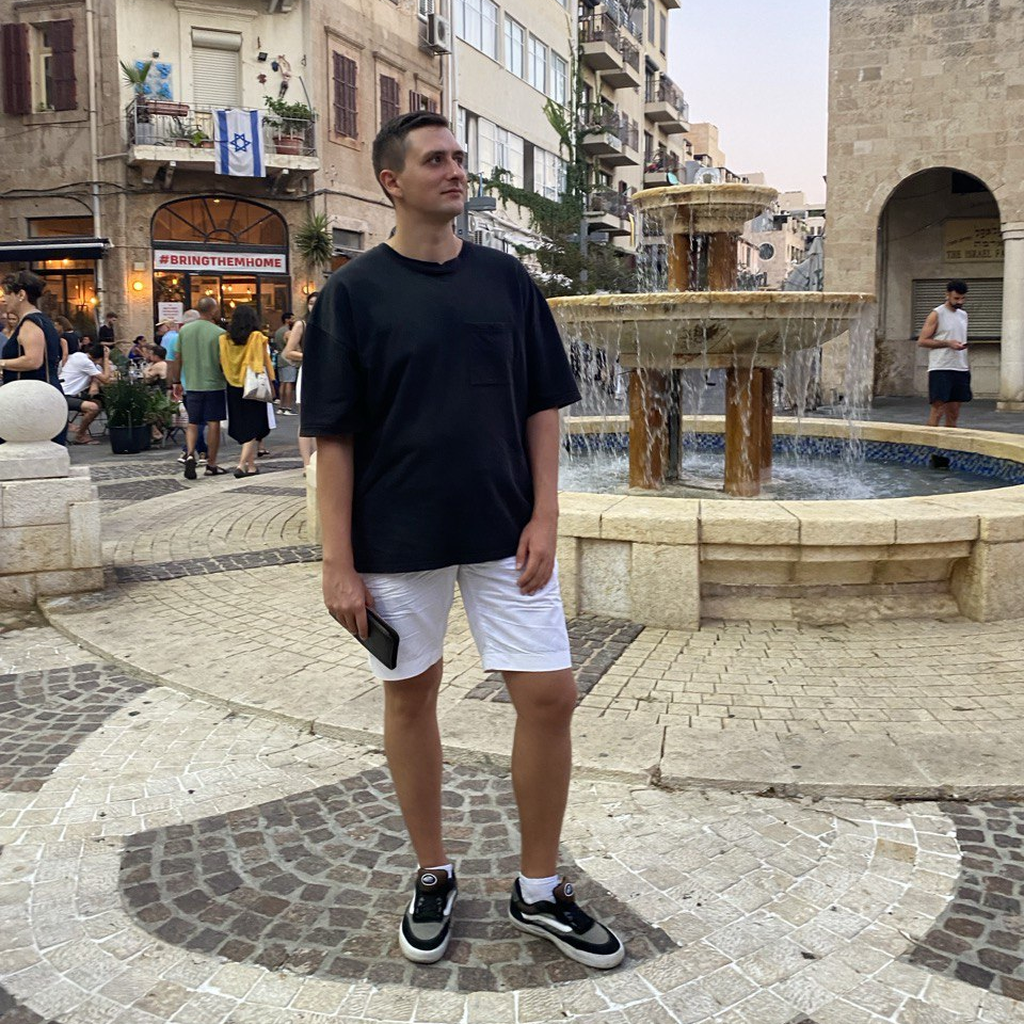

In [85]:
image_croped

# Caption

In [28]:
capt = run_example("<MORE_DETAILED_CAPTION>", image_croped)['<MORE_DETAILED_CAPTION>']
capt

'The image shows a man working on a pottery wheel in a workshop. He is wearing a blue polo shirt and an apron and has a beard. The man is sitting at a wooden table and is focused on his work. He appears to be working on the wheel with a focused expression on his face. On the table, there are various tools and materials scattered around, including a small bowl, a small wooden box, and a few pieces of wood. In the background, there is a white chair and a window with a view of the outside. The overall atmosphere of the workshop is one of concentration and focus.'